# The Fairlearn Trial Executions Part 1

## Single sensitive feature metric

Note: if it is the first time of running this notebook, first type 'pip install fairlearn'

The Fairlearn package is most applicable to two kinds of harms:

1-Allocation harms can occur when AI systems extend or withhold opportunities, resources, or information. Some of the key applications are in hiring, school admissions, and lending.

1-Quality-of-service harms can occur when a system does not work as well for one person as it does for another, even if no opportunities, resources, or information are extended or withheld. Examples include varying accuracy in face recognition, document search, or product recommendation.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from fairlearn import show_versions
show_versions()

C:\Users\hatta\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(



System:
    python: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\hatta\anaconda3\python.exe
   machine: Windows-10-10.0.18362-SP0

Python dependencies:
    Cython: 0.29.21
matplotlib: 3.2.2
     numpy: 1.18.5
    pandas: 1.0.5
       pip: 20.1.1
     scipy: 1.5.0
setuptools: 49.2.0.post20200714
   sklearn: 0.23.1
    tempeh: None


In [2]:
#this is the adult dataset
data = fetch_openml(data_id=1590, as_frame=True)
print(data.data.head(5))
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1

    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

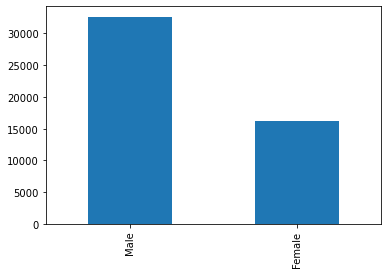

In [3]:
sex = data.data['sex']
sex.value_counts()
sex.value_counts().plot(kind='bar')

In [4]:
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
gm = MetricFrame(accuracy_score, y_true, y_pred, sensitive_features=sex)
print(gm.overall)

0.8443552680070431


### Check the accuracy rate per sensitive feature group

In [5]:
print(gm.by_group)

sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: object


### Check the selection rate per sensitive feature group

Note that the fairlearn.metrics.MetricFrame object requires a minimum of four arguments:

1-The underlying metric function(s) to be evaluated

2-The true values

3-The predicted values

4-The sensitive feature values

In [6]:
from fairlearn.metrics import selection_rate
sr = MetricFrame(selection_rate, y_true, y_pred, sensitive_features=sex)
sr.overall

0.16385487899758405

In [7]:
sr.by_group

sex
Female    0.0635499
Male       0.213599
Name: selection_rate, dtype: object

## The Interactive Dashboard

In [9]:
from fairlearn.widget import FairlearnDashboard
#names = list['sex', 'race', 'workclass', 'marital-status', 'native-country']
FairlearnDashboard(sensitive_features=sex,
                    sensitive_feature_names=['sex'],
                    y_true=y_true,
                    y_pred={"initial model": y_pred}) 

C:\Users\hatta\anaconda3\lib\site-packages\fairlearn\widget\_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

### Mitigating Disparity ( The Exponentiated Gradient mitigation technique used fits the provided classifier using Demographic Parity as the objective)

In Fairlearn, the following types of parity constraints are considered:

-__Binary classification__:

_Demographic parity_ (also known as statistical parity): A classifier _h_ satisfies demographic parity under a distribution over (X,A,Y) if its prediction _h_ (X) is statistically independent of the sensitive feature A. This is equivalent to $ E[h(X)|A=a]=E[h(X)]∀a $ .

*Equalized odds* : A classifier _h_ satisfies equalized odds under a distribution over (X,A,Y) if its prediction _h_ (X) is conditionally independent of the sensitive feature A given the label Y. This is equivalent to $ E[h(X)|A=a,Y=y]=E[h(X)|Y=y]∀a,y $ .

*Equal opportunity* : a relaxed version of equalized odds that only considers conditional expectations with respect to positive labels, i.e., Y=1.

-__Regression__:

_Demographic parity_ : A predictor _f_ satisfies demographic parity under a distribution over (X,A,Y) if _f_ (X) is independent of the sensitive feature A. This is equivalent to $ P[f(X)≥z|A=a]=P[f(X)≥z]∀a,z$ .

_Bounded group loss_ : A predictor _f_ satisfies bounded group loss at level ζ under a distribution over (X,A,Y) if $ E[loss(Y,f(X))|A=a]≤ζ∀a$ .

Above, demographic parity seeks to mitigate allocation harms, whereas bounded group loss primarily seeks to mitigate quality-of-service harms. Equalized odds and equal opportunity can be used as a diagnostic for both allocation harms as well as quality-of-service harms.

__Disparity metrics, Group metrics:__ 
    
   Disparity metrics evaluate how far a given predictor departs from satisfying a parity constraint. They can either compare the behavior across different groups in terms of ratios or in terms of differences. For example, for binary classification:

   Demographic parity difference is defined as $(maxaE[h(X)|A=a])−(minaE[h(X)|A=a])$ .

   Demographic parity ratio is defined as $ minaE[h(X)|A=a] / maxaE[h(X)|A=a]$ .

   The Fairlearn package provides the functionality to convert common accuracy and error metrics from scikit-learn to group metrics, i.e., metrics that are evaluated on the entire data set and also on each group individually. Additionally, group metrics yield the minimum and maximum metric value and for which groups these values were observed, as well as the difference and ratio between the maximum and the minimum values.(more information in fairlearn.metrics)

In [10]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
#demographic parity is used as parity constraint
constraint = DemographicParity()
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

In [11]:
#this step takes really long (more than a couple of minutes)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)

In [12]:
#selection rate of the instances = sr
sr_mitigated = MetricFrame({'precision':skm.precision_score, 'recall':skm.recall_score,'selection_r':selection_rate},
                           y_true, y_pred_mitigated, sensitive_features=sex)
print(sr_mitigated.overall)

precision      0.680345
recall         0.472405
selection_r    0.166148
dtype: object


In [13]:
print(sr_mitigated.by_group)

       precision    recall selection_r
sex                                   
Female  0.503182  0.715093    0.155262
Male    0.759864  0.429119    0.171547


In [14]:
#The interactive dashboard to see the results:
FairlearnDashboard(sensitive_features=sex,
                    sensitive_feature_names=['sex'],
                    y_true=y_true.tolist(),
                    y_pred={"initial model": y_pred.tolist(), "mitigated model": y_pred_mitigated.tolist()})

C:\Users\hatta\anaconda3\lib\site-packages\fairlearn\widget\_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

## Multiple sensitive feature metrics (results)

In [24]:
#The functools module is for higher-order functions: functions that act on or return other functions. 
#In general, any callable object can be treated as a function for the purposes of this module.
import functools
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#import the dataset again with predictors and target/result
data = fetch_openml(data_id=1590, as_frame=True)
X_raw = data.data
Y = (data.target == '>50K') * 1
X_raw

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [16]:
#make the race column have only 3 values: White, Black and Other
def race_transform(input_str):
    """Reduce values to White, Black and Other."""
    result = 'Other'
    if input_str == 'White' or input_str == 'Black':
        result = input_str
    return result

#the upcoming warning does not matter.
X_raw['race'] = X_raw['race'].map(race_transform).fillna('Other')
print(np.unique(X_raw['race']))

['Black' 'Other' 'White']


<ipython-input-16-c167c12e556e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_raw['race'] = X_raw['race'].map(race_transform).fillna('Other')


In [17]:
#some example manipulations in the sensitive data. They are made for illustrative purposes
def marriage_transform(m_s_string):
    """Perform some simple manipulations."""
    result = 'Low'
    if m_s_string.startswith("Married"):
        result = 'Medium'
    elif m_s_string.startswith("Widowed"):
        result = 'High'
    return result


def occupation_transform(occ_string):
    """Perform some simple manipulations."""
    result = 'Small'
    if occ_string.startswith("Machine"):
        result = 'Large'
    return result


col_credit = X_raw['marital-status'].map(marriage_transform).fillna('Low')
col_credit.name = "Credit Score"
col_loan_size = X_raw['occupation'].map(occupation_transform).fillna('Small')
col_loan_size.name = "Loan Size"

#A dataset that contains ass the sensitive features
A = X_raw[['race', 'sex']]
A['Credit Score'] = col_credit
A['Loan Size'] = col_loan_size
A

<ipython-input-17-142935c85ec3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A['Credit Score'] = col_credit
<ipython-input-17-142935c85ec3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A['Loan Size'] = col_loan_size


,race,sex,Credit Score,Loan Size
0,Black,Male,Low,Large
1,White,Male,Medium,Small
2,White,Male,Medium,Small
3,Black,Male,Medium,Large
4,White,Female,Low,Small
...,...,...,...,...
48837,White,Female,Medium,Small
48838,White,Male,Medium,Large
48839,White,Female,High,Small
48840,White,Male,Low,Small


In [23]:
#pre-processing with standardization scaling, train and test set splitting

#with label encoder, encode target labels with value between 0 and n_classes-1. Should only be used for target var Y.
le = LabelEncoder()
Y = le.fit_transform(Y)

#scale the data by standardization
sc = StandardScaler()
#Convert categorical variable into dummy/indicator variables.
X_dummies = pd.get_dummies(X_raw)

X_scaled = sc.fit_transform(X_dummies)
X_scaled = pd.DataFrame(X_scaled, columns=X_dummies.columns)
#train-test split of the dataset
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X_scaled, Y, A,
                                                                     test_size=0.3,
                                                                     random_state=12345,
                                                                     stratify=Y)

# Ensure indices are aligned
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,...,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,1.120058,-1.353751,-0.419335,-0.144804,-0.217127,1.579946,-1.506680,3.412743,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
1,0.974183,2.405973,-0.030373,-0.144804,-0.217127,1.579946,0.663711,-0.293019,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
2,0.609496,0.081048,-0.419335,-0.144804,-0.217127,-0.034087,-1.506680,-0.293019,-0.189609,5.753915,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
3,0.682433,0.016333,-0.030373,-0.144804,-0.217127,0.772930,-1.506680,3.412743,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
4,-0.192816,0.244679,-0.419335,-0.144804,-0.217127,1.983455,0.663711,-0.293019,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34184,0.536558,0.032034,-0.419335,-0.144804,-0.217127,-0.034087,0.663711,-0.293019,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
34185,-1.141004,-0.488880,1.136512,-0.144804,3.728278,0.772930,0.663711,-0.293019,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
34186,-0.703379,-0.735142,-0.419335,-0.144804,-0.217127,0.772930,0.663711,-0.293019,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525
34187,-0.192816,1.424457,2.303397,-0.144804,-0.217127,-0.356894,-1.506680,-0.293019,-0.189609,-0.173795,...,-0.042485,-0.03169,-0.02074,-0.024791,-0.021705,-0.056423,-0.023518,-0.030703,-0.024791,-0.004525


In [20]:
#train the model and get the predictions
unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, Y_train)

Y_pred = unmitigated_predictor.predict(X_test)
Y_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

### Analyze the model using different metrics

The __F-beta score__ is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.
The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

In [25]:
print("Selection Rate:", selection_rate(Y_test, Y_pred))
print("fbeta:", skm.fbeta_score(Y_test, Y_pred, beta=0.6))

Selection Rate: 0.20050501603767146
fbeta: 0.6819168793569769


__functools.partial():__
    Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguments keywords. 
    If more arguments are supplied to the call, they are appended to args. If additional keyword arguments are supplied, they extend and override keywords.
    
   The _partial()_ is used for partial function application which “freezes” some portion of a function’s arguments and/or keywords resulting in a new object with a simplified signature. For example, partial() can be used to create a callable that behaves like the int() function where the base argument defaults to two.
 

In [ ]:
#The underlying metrics must have a signature fn(y_true, y_pred), so we have to use functools.partial() on fbeta_score() to furnish beta=0.6
fbeta_06 = functools.partial(skm.fbeta_score, beta=0.6)

metric_fns = {'selection_rate': selection_rate, 'fbeta_06': fbeta_06}
grouped_on_sex = MetricFrame(metric_fns,
                             Y_test, Y_pred,
                             sensitive_features=A_test['sex'])

In [27]:
assert grouped_on_sex.overall['selection_rate'] == selection_rate(Y_test, Y_pred)
assert grouped_on_sex.overall['fbeta_06'] == skm.fbeta_score(Y_test, Y_pred, beta=0.6)
print(grouped_on_sex.overall)
print(grouped_on_sex.by_group)
#note: Assertions are simply boolean expressions that check if the conditions return true or not. 
#If it is true, the program does nothing and move to the next line of code. 
#However, if it's false, the program stops and throws an error.

selection_rate    0.200505
fbeta_06          0.681917
dtype: object
       selection_rate  fbeta_06
sex                            
Female      0.0730349  0.639174
Male         0.263512    0.6882


In [28]:
#disparity among races
grouped_on_race = MetricFrame(metric_fns,
                              Y_test, Y_pred,
                              sensitive_features=A_test['race'])

In [29]:
assert (grouped_on_sex.overall == grouped_on_race.overall).all()
print(grouped_on_race.by_group)

      selection_rate  fbeta_06
race                          
Black      0.0766017   0.60886
Other       0.189607  0.648637
White       0.215354  0.686801


Fairlearn supports arguments which have one entry for each sample, with an array of sample weights being the most common example. These are divided into subgroups along with y_true and y_pred, and passed along to the underlying metric. To use these arguments, pass them in a dictionary as the sample_params= argument of the constructor.

In [30]:
random_weights = np.random.rand(len(Y_test))

example_sample_params = {
    'selection_rate': {'sample_weight': random_weights},
    'fbeta_06': {'sample_weight': random_weights},
}


grouped_with_weights = MetricFrame(metric_fns,
                                   Y_test, Y_pred,
                                   sensitive_features=A_test['sex'],
                                   sample_params=example_sample_params)

In [32]:
assert grouped_with_weights.overall['selection_rate'] == \
    selection_rate(Y_test, Y_pred, sample_weight=random_weights)
assert grouped_with_weights.overall['fbeta_06'] == \
    skm.fbeta_score(Y_test, Y_pred, beta=0.6, sample_weight=random_weights)
print(grouped_with_weights.overall)
print(grouped_with_weights.by_group)

selection_rate    0.199729
fbeta_06          0.689475
dtype: object
       selection_rate  fbeta_06
sex                            
Female      0.0703117  0.618403
Male         0.263153   0.69949


## Quantifying  Disparities (aggregating metrics across the subgroups)

In [37]:
#min subgroup
print(grouped_on_race.group_min())
#subgroup differences: the difference in selection rates can be quantified in terms of a difference between the subgroup 
#with the highest value of the metric, and the subgroup with the lowest value. 
print(grouped_on_race.difference(method='between_groups'))

selection_rate    0.0766017
fbeta_06            0.60886
dtype: object
selection_rate    0.138752
fbeta_06          0.077941
dtype: float64


In [34]:
#We can also evaluate the difference relative to the corresponding overall value of the metric. 
#In this case we take the absolute value, so that the result is always positive:
grouped_on_race.difference(method='to_overall')

selection_rate    0.123903
fbeta_06          0.073057
dtype: float64

In [39]:
#Note: There are situations where knowing the ratios of the metrics evaluated on the subgroups is more useful. 
print(grouped_on_race.ratio(method='between_groups'))
print(grouped_on_race.ratio(method='to_overall'))

selection_rate    0.355701
fbeta_06          0.886516
dtype: object
selection_rate    0.382044
fbeta_06          0.892865
dtype: float64


## Intersection of Features ***

In [35]:
grouped_on_race_and_sex = MetricFrame(metric_fns,
                                      Y_test, Y_pred,
                                      sensitive_features=A_test[['race', 'sex']])
assert (grouped_on_race_and_sex.overall == grouped_on_race.overall).all()
grouped_on_race_and_sex.by_group

selection_rate  fbeta_06
race  sex                            
Black Female      0.0235784    0.6206
      Male          0.13007   0.60627
Other Female      0.0711462  0.539683
      Male         0.254902  0.667157
White Female      0.0823651  0.646108
      Male         0.275023  0.692614

In [40]:
print(grouped_on_race_and_sex.group_min())
print(grouped_on_race_and_sex.ratio(method='between_groups'))

selection_rate    0.0235784
fbeta_06           0.539683
dtype: object
selection_rate    0.0857323
fbeta_06           0.779197
dtype: object


## Control Features (to slice the data further)

There is a further way we can slice up our data. We have (completely made up) features for the individuals’ credit scores (in three bands) and also the size of the loan requested (large or small). In our loan scenario, it is acceptable that individuals with high credit scores are selected more often than individuals with low credit scores. However, within each credit score band, we do not want a disparity between (say) black females and white males. To example these cases, we have the concept of control features.

In [41]:
cond_credit_score = MetricFrame(metric_fns,
                                Y_test, Y_pred,
                                sensitive_features=A_test[['race', 'sex']],
                                control_features=A_test['Credit Score'])
print(cond_credit_score.overall)
print(cond_credit_score.by_group)

             selection_rate  fbeta_06
Credit Score                         
High              0.0367965  0.556675
Low               0.0195585  0.515224
Medium             0.395422  0.695178
                          selection_rate  fbeta_06
Credit Score race  sex                            
High         Black Female              0         0
                   Male              0.2         1
             Other Female              0         0
                   Male                0         0
             White Female       0.012945  0.418033
                   Male         0.151899  0.625767
Low          Black Female     0.00176367  0.274194
                   Male        0.0179028  0.480565
             Other Female              0         0
                   Male         0.011236   0.60177
             White Female      0.0136555  0.450228
                   Male        0.0303738  0.562242
Medium       Black Female       0.153846  0.697161
                   Male         0.266458  0.6

In [42]:
#The aggregates are also evaluated once for each group identified by the control feature:
cond_credit_score.group_min()
# it can be seen that  we have a dearth of positive results for high income non-whites, which significantly affects the aggregates.

,selection_rate,fbeta_06
Credit Score,,
High,0.000000,0.000000
Low,0.000000,0.000000
Medium,0.153846,0.602254


In [43]:
#with more control features
cond_both = MetricFrame(metric_fns,
                        Y_test, Y_pred,
                        sensitive_features=A_test[['race', 'sex']],
                        control_features=A_test[['Loan Size', 'Credit Score']])

Found 36 subgroups. Evaluation may be slow
C:\Users\hatta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [44]:
cond_both.overall

selection_rate  fbeta_06
Loan Size Credit Score                         
Large     High                      0         0
          Low              0.00697674  0.790698
          Medium            0.0669643  0.406143
Small     High              0.0397196  0.563057
          Low               0.0203627  0.510146
          Medium             0.417768  0.700509

In [45]:
cond_both.by_group
#note: NaN values indicate that there were no samples in the cell

selection_rate  fbeta_06
Loan Size Credit Score race  sex                            
Large     High         Black Female              0         0
                             Male              NaN       NaN
                       Other Female            NaN       NaN
                             Male              NaN       NaN
                       White Female              0         0
                             Male                0         0
          Low          Black Female              0         0
                             Male                0         0
                       Other Female              0         0
                             Male                0         0
                       White Female              0         0
                             Male        0.0148515  0.790698
          Medium       Black Female              0         0
                             Male        0.0322581  0.350515
                       Other Female            0.2         0
                             Male                0         0
                       White Female      0.0909091  0.492754
                             Male        0.0710227  0.426481
Small     High         Black Female              0         0
                             Male              0.2         1
                       Other Female              0         0
                             Male                0         0
                       White Female       0.013986  0.418033
                             Male         0.157895    0.6375
          Low          Black Female      0.0019685  0.274194
                             Male         0.019337  0.480565
                       Other Female              0         0
                             Male        0.0123457   0.60177
                       White Female      0.0142492  0.450228
                             Male        0.0314961  0.555266
          Medium       Black Female           0.16    0.7072
                             Male         0.291667  0.621613
                       Other Female       0.274194  0.627517
                             Male          0.45098  0.679826
                       White Female       0.404444  0.699767
                             Male         0.431508  0.705253

In [46]:
#there is an underpopulation for certain subgroups.
#count the instances that belong to each sub-category
def member_counts(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return len(y_true)


counts = MetricFrame(member_counts,
                     Y_test, Y_pred,
                     sensitive_features=A_test[['race', 'sex']],
                     control_features=A_test[['Loan Size', 'Credit Score']])

counts.by_group

Found 36 subgroups. Evaluation may be slow


Loan Size  Credit Score  race   sex   
Large      High          Black  Female       8
                                Male       NaN
                         Other  Female     NaN
                                Male       NaN
                         White  Female      23
                                Male         3
           Low           Black  Female      59
                                Male        29
                         Other  Female       5
                                Male        16
                         White  Female     119
                                Male       202
           Medium        Black  Female       4
                                Male        31
                         Other  Female       5
                                Male        23
                         White  Female      33
                                Male       352
Small      High          Black  Female      42
                                Male         5
                     

In [51]:
#the interactive dashboard
FairlearnDashboard(sensitive_features=A_test[['race', 'sex']],
                    sensitive_feature_names=[['race'],['sex']],
                    y_true=Y_test,
                    y_pred={"initial model": Y_pred}) 

FairlearnWidget(value={'true_y': [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1…

In [61]:
#try to mitigate the model with demographic parity (takes quite long ~8mins)
constraint2 = DemographicParity()
classifier2 = LogisticRegression(solver='liblinear', fit_intercept=True)

mitigator2 = ExponentiatedGradient(classifier2, constraint2)
mitigator2.fit(X_train, Y_train, sensitive_features=A_train[['race', 'sex']])
y_pred_mitigated2 = mitigator2.predict(X_test)

In [62]:
fbeta_06 = functools.partial(skm.fbeta_score, beta=0.6)

sr_mitigated = MetricFrame({'fbeta':fbeta_06, 'precision':skm.precision_score, 'recall':skm.recall_score,'selection_r':selection_rate},
                           Y_test, y_pred_mitigated2, sensitive_features=A_test[['race', 'sex']],
                           control_features=A_test[['Loan Size', 'Credit Score']])

C:\Users\hatta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Found 36 subgroups. Evaluation may be slow
C:\Users\hatta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\hatta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print(sr_mitigated.overall)

                           fbeta precision    recall selection_r
Loan Size Credit Score                                          
Large     High                 0         0         0           0
          Low                  0         0         0           0
          Medium        0.318501  0.571429  0.142857      0.0625
Small     High          0.509251  0.548387     0.425   0.0724299
          Low           0.465267  0.584158  0.297229   0.0300238
          Medium        0.674815  0.733875  0.551525    0.336674


In [56]:
print(sr_mitigated.by_group)

                                    precision     recall selection_r
Loan Size Credit Score race  sex                                    
Large     High         Black Female         0          0           0
                             Male         NaN        NaN         NaN
                       Other Female       NaN        NaN         NaN
                             Male         NaN        NaN         NaN
                       White Female         0          0           0
                             Male           0          0           0
          Low          Black Female         0          0           0
                             Male           0          0           0
                       Other Female         0          0           0
                             Male           0          0           0
                       White Female         0          0           0
                             Male           1   0.166667   0.0049505
          Medium       Black Femal

In [64]:
#comparison of logistic regression models with and without mitigation on dashboard
FairlearnDashboard(sensitive_features=A_test[['race', 'sex']],
                    sensitive_feature_names=[['race'],['sex']],
                    y_true=Y_test,
                    y_pred={"initial model": Y_pred.tolist(), "mitigated model": y_pred_mitigated2.tolist()}) 

C:\Users\hatta\anaconda3\lib\site-packages\fairlearn\widget\_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1…